# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

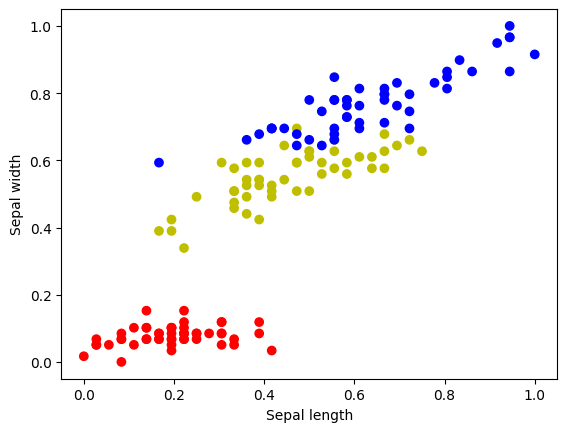

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [5]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [6]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.4789,  0.6856],
                      [-0.6431,  0.4099],
                      [-0.2748,  0.4538]])),
             ('bias', tensor([-0.3441, -0.0567,  0.0375]))])

### Fazendo um predict

In [7]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.4040, -0.1718,  0.0071],
        [-0.3774, -0.1361,  0.0224],
        [-0.3624, -0.1073,  0.0300],
        [-0.3259, -0.0755,  0.0530]], grad_fn=<AddmmBackward0>)

In [8]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.2653, 0.3346, 0.4002],
        [0.2656, 0.3381, 0.3962],
        [0.2652, 0.3422, 0.3926],
        [0.2670, 0.3430, 0.3900]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [9]:
F.softmax(out,dim=1)*100

tensor([[26.5255, 33.4593, 40.0151],
        [26.5639, 33.8149, 39.6213],
        [26.5168, 34.2240, 39.2592],
        [26.7012, 34.2976, 39.0012]], grad_fn=<MulBackward0>)

### Predição da classe

In [10]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4002, 0.3962, 0.3926, 0.3900], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [11]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [12]:
lr = 10

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.08075638115406036


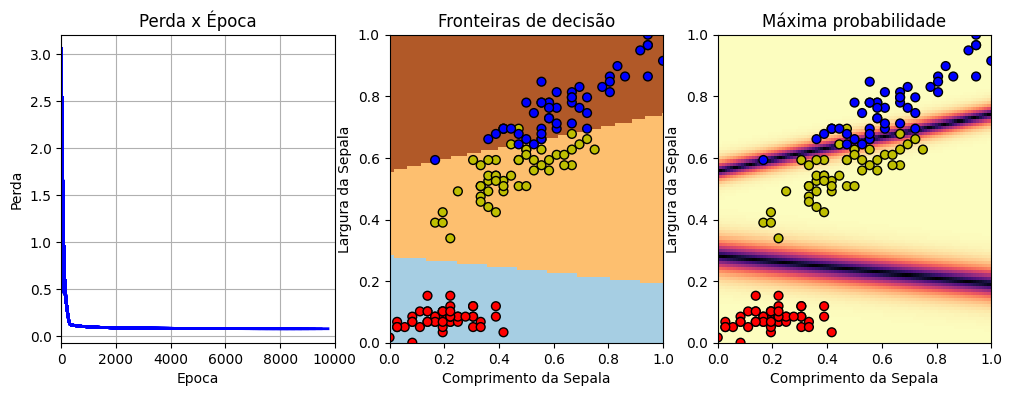

In [13]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [14]:
model.state_dict()

OrderedDict([('weight',
              tensor([[  1.4526, -50.0558],
                      [  5.0424,  -9.4791],
                      [ -7.8919,  61.0838]])),
             ('bias', tensor([ 20.6176,   9.1996, -30.1807]))])

### Salvando os parâmetros treinados

In [15]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [16]:
! ls ../models/

RegrLog_Iris.pt


In [17]:
nn.init.constant(model.weight,0)
nn.init.constant(model.bias,0)
model.state_dict()

<ipython-input-17-40538c5b1ce1>:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)
<ipython-input-17-40538c5b1ce1>:2: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.bias,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([0., 0., 0.]))])

### Recuperando os pesos salvos

In [18]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

<ipython-input-18-079748b01dc8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_saved = torch.load('../models/RegrLog_Iris.pt')


OrderedDict([('weight',
              tensor([[  1.4526, -50.0558],
                      [  5.0424,  -9.4791],
                      [ -7.8919,  61.0838]])),
             ('bias', tensor([ 20.6176,   9.1996, -30.1807]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [19]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.9666666666666667


### Matriz de confusão

In [20]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,2
2,0,3,48


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

Reposta: É necessário instanciar a rede novamente para resetar os pesos.

2. Experimente refazer o treinamento com diferentes valores de learning rate


Final loss: 0.0807560384273529
Training Accuracy: 0.9666666666666667
Resultados dos Experimentos:
Learning Rate: 0.001 | Final Loss: 0.9361243844032288 | Accuracy: 0.6933333333333334
Learning Rate: 0.01 | Final Loss: 0.49923157691955566 | Accuracy: 0.8666666666666667
Learning Rate: 0.1 | Final Loss: 0.24228960275650024 | Accuracy: 0.9466666666666667
Learning Rate: 1 | Final Loss: 0.10606838017702103 | Accuracy: 0.9666666666666667
Learning Rate: 10 | Final Loss: 0.0807560384273529 | Accuracy: 0.9666666666666667


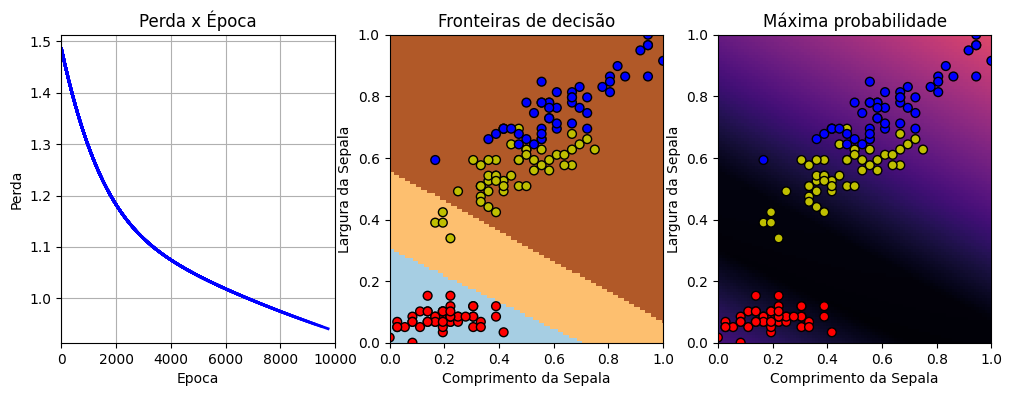

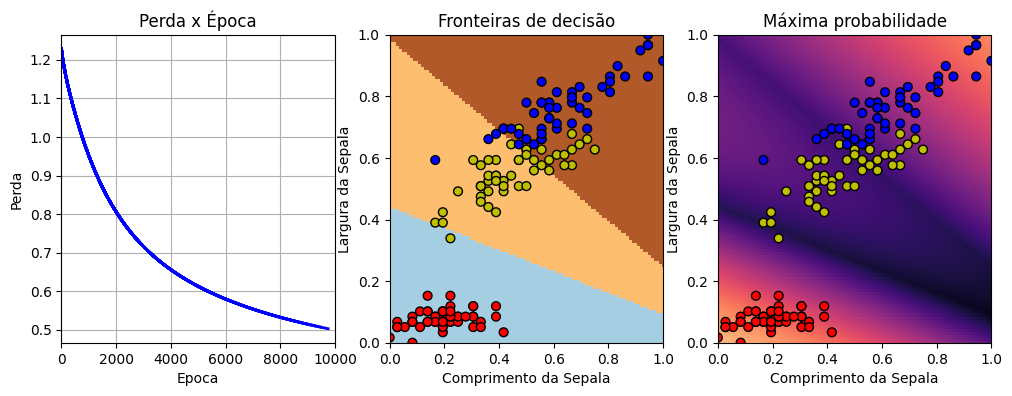

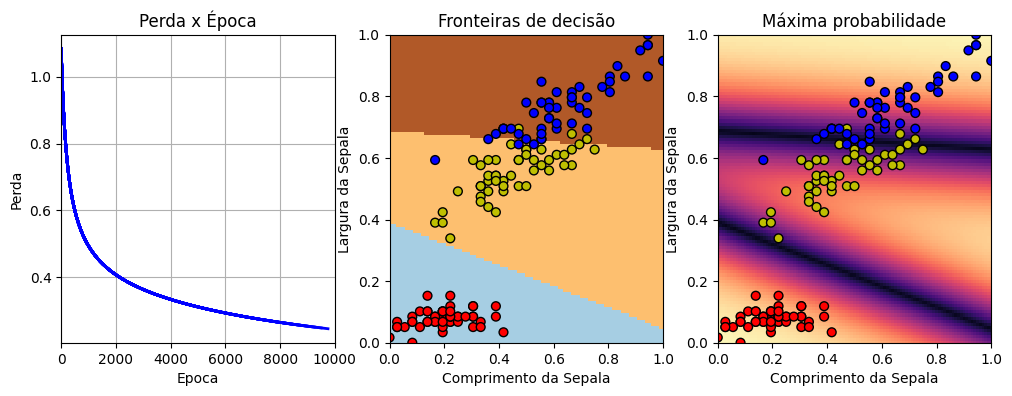

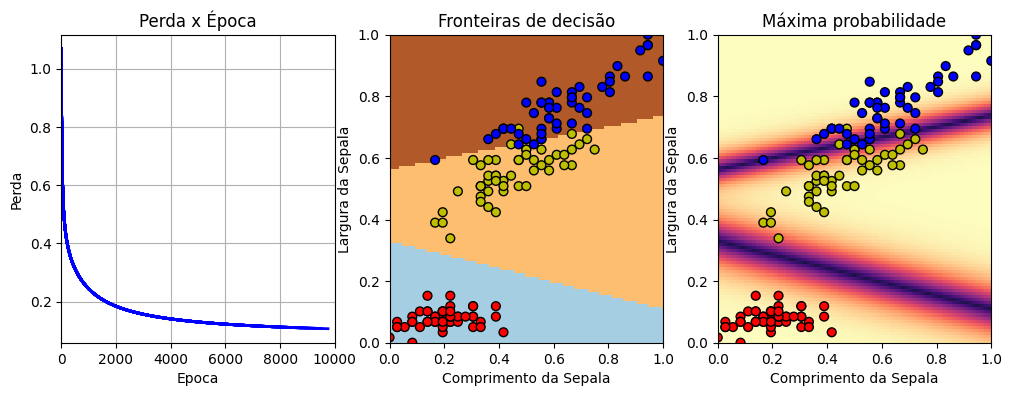

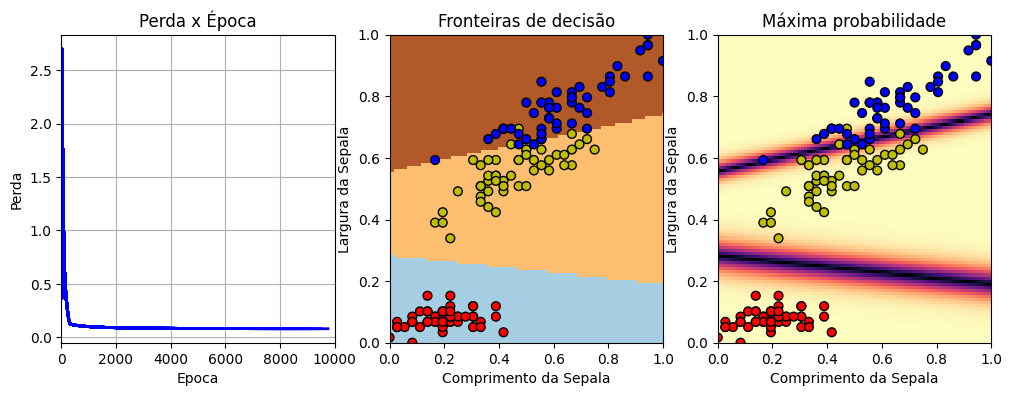

In [21]:
# Lista de learning rates para experimentar
learning_rates = [0.001, 0.01, 0.1, 1, 10]

# Número de épocas
nb_epoch = 10000

# Armazenar os resultados
results = {}

# Experimento para cada learning rate
for lr in learning_rates:
    print(f"TREINANDO COM LEARNING RATE: {lr}")

    # Reinicialize o modelo
    model = nn.Linear(2, 3)  # Recrie o modelo com pesos aleatórios
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Inicialize o plotter para visualização
    my_plot = MyPlotter(model, Xc, Y, nb_epoch)

    # Treinamento
    losses = []
    for i in range(nb_epoch):
        # Previsão do modelo
        output = model(Variable(X_tensor))

        # Calcula a perda
        loss = criterion(output, Variable(Y_tensor))

        # Atualiza os gradientes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Salva a perda atual
        losses.append(loss.data.item())
        my_plot.on_epoch_end(i, {'loss': loss.data.item()})

    # Resultados após treinamento
    final_loss = loss.data.item()
    Y_pred = predict(model, X_tensor)
    accuracy = (Y_pred == Y).mean()

    print(f"Final loss: {final_loss}")
    print(f"Training Accuracy: {accuracy}")
    print("=" * 50)

    # Armazena os resultados para análise posterior
    results[lr] = {'loss': final_loss, 'accuracy': accuracy}

# Comparar os resultados
print("Resultados dos Experimentos:")
for lr, metrics in results.items():
    print(f"Learning Rate: {lr} | Final Loss: {metrics['loss']} | Accuracy: {metrics['accuracy']}")


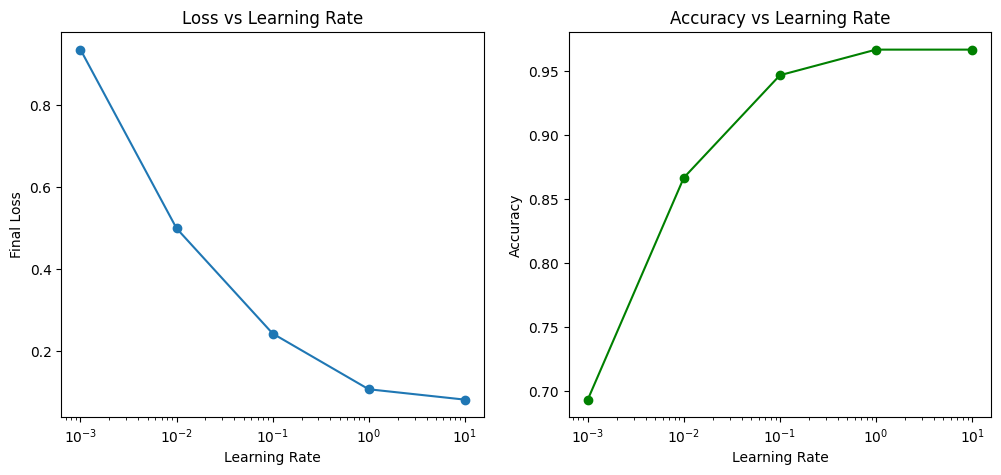

In [22]:
import matplotlib.pyplot as plt

lrs = list(results.keys())
losses = [results[lr]['loss'] for lr in lrs]
accuracies = [results[lr]['accuracy'] for lr in lrs]

plt.figure(figsize=(12, 5))

# Gráfico de perda
plt.subplot(1, 2, 1)
plt.plot(lrs, losses, marker='o')
plt.xscale('log')  # Escala logarítmica
plt.xlabel('Learning Rate')
plt.ylabel('Final Loss')
plt.title('Loss vs Learning Rate')

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(lrs, accuracies, marker='o', color='green')
plt.xscale('log')  # Escala logarítmica
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')

plt.show()


### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade? As azuis mais superiores e as vermelhas mais inferiores
    

    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    Os azuis e os amarelos que estão descolados dos outros

    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    Os mais inferiores dos amarelos.


    4. Qual é a amostra classificada erradamente, com menor probabilidade?
    Os menos valores entre os azuis

2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?

Resposta: 9.

3. Quantas entradas e quantas saídas esta rede possui?

2 entradas e 3 saídas.

4. Como se pode calcular a acurácia a partir da matriz de confusão?
Acurácia = Número de predições corretas dividido por número total de amostras.

5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max


Resposta:

torch.max(input, dim) retorna:
max_values: Os valores máximos ao longo de um eixo especificado.
indices: Os índices das posições dos valores máximos.

## Principais aprendizados

- Treinamento com diferentes valores de learning rate
- Interpretação dos gráficos de perda x época, fronteiras de decisão e máxima probabilidade